<a href="https://colab.research.google.com/github/CelikAbdullah/deep-learning-notebooks/blob/main/Deep%20Reinforcement%20Learning/Actor-Critic/DDPG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

import gym
import time
from itertools import count

# Q Value Network as Critic

In [2]:
class QValueNetwork(nn.Module):
  def __init__(self,
               input_dim,
               output_dim,
               hidden_dims=(32,32),
               activation_fc=F.relu):
    super(QValueNetwork, self).__init__()

    # set the activation layer
    self.activation_fc = activation_fc

    # input layer
    self.input_layer = nn.Linear(input_dim, hidden_dims[0])
    # hidden layer(s)
    self.hidden_layers = nn.ModuleList()
    for i in range(len(hidden_dims)-1):
      in_dim = hidden_dims[i]
      if i == 0:
        in_dim += output_dim
      hidden_layer = nn.Linear(in_dim, hidden_dims[i+1])
      self.hidden_layers.append(hidden_layer)
    # output layer
    self.output_layer = nn.Linear(hidden_dims[-1], 1)

    device = "cpu"
    if torch.cuda.is_available():
      device = "cuda:0"
    self.device = torch.device(device)
    self.to(self.device)

  def _format(self, state, action):
    x, u = state, action
    if not isinstance(x, torch.Tensor):
      x = torch.tensor(x, device=self.device, dtype=torch.float32)
      x = x.unsqueeze(0)

    if not isinstance(u, torch.Tensor):
      u = torch.tensor(u, device=self.device, dtype=torch.float32)
      u = u.unsqueeze(0)

    return x, u

  def forward(self, state, action):
    # format the state & action
    x, u = self._format(state, action)

    # pass formatted state through the layers
    x = self.activation_fc(self.input_layer(x))
    for i, hidden_layer in enumerate(self.hidden_layers):
      if i == 0:
        x = torch.cat((x, u), dim=1)
      x = self.activation_fc(hidden_layer(x))
    return self.output_layer(x)

  def load(self, experiences):
    states, actions, new_states, rewards, is_terminals = experiences
    states = torch.from_numpy(states).float().to(self.device)
    actions = torch.from_numpy(actions).float().to(self.device)
    new_states = torch.from_numpy(new_states).float().to(self.device)
    rewards = torch.from_numpy(rewards).float().to(self.device)
    is_terminals = torch.from_numpy(is_terminals).float().to(self.device)

    return states, actions, new_states, rewards, is_terminals

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Deterministic Policy Network as Actor

In [3]:
class DPolicyNetwork(nn.Module):
  def __init__(self,
               input_dim,
               action_bounds,
               hidden_dims=(32,32),
               activation_fc=F.relu,
               out_activation_fc=F.tanh):

    super(DPolicyNetwork, self).__init__()
    self.activation_fc = activation_fc
    self.out_activation_fc = out_activation_fc
    self.env_min, self.env_max = action_bounds

    # input layer
    self.input_layer = nn.Linear(input_dim, hidden_dims[0])
    # hidden layers
    self.hidden_layers = nn.ModuleList()
    for i in range(len(hidden_dims)-1):
      hidden_layer = nn.Linear(hidden_dims[i], hidden_dims[i+1])
      self.hidden_layers.append(hidden_layer)
    # output layer
    self.output_layer = nn.Linear(hidden_dims[-1], len(self.env_max))

    device = "cpu"
    if torch.cuda.is_available():
      device = "cuda:0"
    self.device = torch.device(device)
    self.to(self.device)

    self.env_min = torch.tensor(self.env_min,
                                device=self.device,
                                dtype=torch.float32)

    self.env_max = torch.tensor(self.env_max,
                                device=self.device,
                                dtype=torch.float32)

    self.nn_min = self.out_activation_fc(torch.Tensor([float('-inf')])).to(self.device)
    self.nn_max = self.out_activation_fc(torch.Tensor([float('inf')])).to(self.device)
    self.rescale_fn = lambda x: (x - self.nn_min) * (self.env_max - self.env_min) / (self.nn_max - self.nn_min) + self.env_min

  def _format(self, state):
    '''
    Format the state.
    '''
    x = state
    if not isinstance(x, torch.Tensor):
      x = torch.tensor(x, device=self.device, dtype=torch.float32)
      x = x.unsqueeze(0)
    return x

  def forward(self, state):
    '''
    Forward pass.
    '''

    x = self._format(state)
    x = self.activation_fc(self.input_layer(x))
    for hidden_layer in self.hidden_layers:
      x = self.activation_fc(hidden_layer(x))

    x = self.output_layer(x)
    x = self.out_activation_fc(x)

    return self.rescale_fn(x)

# Replay Buffer

The DDPG agent will use a replay buffer to train an action-value function in an off-policy manner.

In [4]:
class ReplayBuffer():

  # our replay buffer has a default max size of 10000 and uses a batch size of 64
  def __init__(self, max_size=10000, batch_size=64):
    # initialize five empty NumPy arrays that will hold states, actions, rewards, next_states and done flags
    self.ss_mem = np.empty(shape=(max_size), dtype=np.ndarray)
    self.as_mem = np.empty(shape=(max_size), dtype=np.ndarray)
    self.rs_mem = np.empty(shape=(max_size), dtype=np.ndarray)
    self.ps_mem = np.empty(shape=(max_size), dtype=np.ndarray)
    self.ds_mem = np.empty(shape=(max_size), dtype=np.ndarray)
    self.max_size = max_size
    self.batch_size = batch_size
    self._idx = 0
    self.size = 0

  def store(self, sample):
    '''
    Store the components of the experience into the corresponding NumPy array.
    '''
    # unwrap the experience which is just a tuple
    s, a, r, p, d = sample
    # store each component to its corresponding NumPy array
    self.ss_mem[self._idx] = s
    self.as_mem[self._idx] = a
    self.rs_mem[self._idx] = r
    self.ps_mem[self._idx] = p
    self.ds_mem[self._idx] = d
    # adjust the index
    self._idx += 1
    # if the replay buffer is full, we wrap around and overwrite older experiences with new ones
    self._idx = self._idx % self.max_size
    # adjust the size
    self.size += 1
    # determine the size
    self.size = min(self.size, self.max_size)

  def sample(self, batch_size=None):
    '''
    Sample a mini-batch of experiences from the replay buffer.
    '''
    if batch_size == None:
      batch_size = self.batch_size

    # Generate a uniform random sample from np.arange(self.size) of size 'batch_size' without replacement:
    idxs = np.random.choice(self.size, batch_size, replace=False)

    # create the mini-batch of experiences
    experiences = np.vstack(self.ss_mem[idxs]), \
                      np.vstack(self.as_mem[idxs]), \
                      np.vstack(self.rs_mem[idxs]), \
                      np.vstack(self.ps_mem[idxs]), \
                      np.vstack(self.ds_mem[idxs])

    return experiences

  def __len__(self):
    return self.size

# Exploration Strategies

The greedy strategy:

In [5]:
class GreedyStrategy():
  def __init__(self, bounds):
    # set some attributes
    self.low, self.high = bounds

  def select_action(self, model, state):
    with torch.no_grad():
      # get greedy action from the policy model
      greedy_action = model(state).cpu().detach().data.numpy().squeeze()

    # clip the action to be in range
    action = np.clip(greedy_action, self.low, self.high)
    # reshape and return action
    return np.reshape(action, self.high.shape)

The policy being optimized is deterministic. A deterministic policy returns the same action everytime it's queried. So, the DDPG agent needs off-policy strategies for exploration. Therefore, DDPG injects Gaussian noise into the actions selected by the policy. The logic for this is implemented in the NormalNoiseStrategy class:

In [6]:
class NormalNoiseStrategy():
  def __init__(self, bounds, exploration_noise_ratio=0.1):
    # set some attributes
    self.low, self.high = bounds
    self.exploration_noise_ratio = exploration_noise_ratio
    self.ratio_noise_injected = 0

  def select_action(self, model, state, max_exploration=False):
    if max_exploration:
      # set the noise scale to the maximum action to maximize exploration
      noise_scale = self.high
    else:
      # scale the noise down
      noise_scale = self.exploration_noise_ratio * self.high
    with torch.no_grad():
      # get the greedy action from the policy network
      greedy_action = model(state).cpu().detach().data.numpy().squeeze()
    # compute the Gaussian noise for the action using the scale and 0 mean
    noise = np.random.normal(loc=0, scale=noise_scale, size=len(self.high))
    # add noise to the action
    noisy_action = greedy_action + noise
    # clip action to be in range
    action = np.clip(noisy_action, self.low, self.high)
    # update the noise ratio schedule
    self.ratio_noise_injected = np.mean(abs((greedy_action - action)/(self.high - self.low)))
    # return the action with injected Gaussion noise
    return action

# DDPG agent

DDPG stands for "deep deterministic policy gradient". We can think of DDPG as a DQN for continuous action spaces. DDPG uses many of the same techniques found in DQN (e.g. a replay buffer to train an action-value function in a off-policy manner and target networks to stabilize training.)

The biggest difference between DQN and DDPG: DQN uses the target Q-network for getting the greedy action using an argmax; DDPG uses a target determinisic policy function trained to approximate the greedy action.
So, in DDPQ, we directly approximate the best action in the next state using a policy function.

Just like the DQN agent, the DDPG agent collects experiences in an online manner and stores these online experience samples into a replay buffer, during training. On every step, the agent pulls out a mini-batch from the replay buffer that is commonly sampled uniformly at random. The agent then uses this mini-batch to calculate a bootstrapped TD target and train a Q function.
In DDPG, a target deterministic policy function is trained to approximate the greedy action; so, we directly approximate the best action in the next state using a policy function. Then, we pass that action to the Q function to get the max value.

The DDPG value function objective:

$L_i(\theta_i) = \mathbb{E}_{(s,a,r,s') \sim U(D)}[(r+\gamma Q(s', \mu(s'; \phi^-); \theta^-) - Q(s,a; \theta_i))^2]$

The policy network will also be trained so that it can give us the optimal action in a given state. The DDPG deterministic policy objective looks like the following:

$J_i(\phi_i) = \mathbb{E}_{s \sim U(D)}[Q(s, \mu(s; \phi); \theta)]$

In [7]:
class DDPG():
  def __init__(self,
              env,
              online_policy_model,
              target_policy_model,
              policy_max_grad_norm,
              policy_optimizer,
              online_value_model,
              target_value_model,
              value_max_grad_norm,
              value_optimizer,
              training_strategy,
              evaluation_strategy,
              replay_buffer,
              warmup_batches,
              update_target_steps,
              tau,
              seed,
              gamma,
              max_minutes,
              max_episodes,
              goal):

    # set the attributes
    self.env = env
    self.online_policy_model = online_policy_model
    self.target_policy_model = target_policy_model
    self.policy_max_grad_norm = policy_max_grad_norm
    self.policy_optimizer = policy_optimizer
    self.online_value_model = online_value_model
    self.target_value_model = target_value_model
    self.value_max_grad_norm = value_max_grad_norm
    self.value_optimizer = value_optimizer
    self.training_strategy = training_strategy
    self.evaluation_strategy = evaluation_strategy
    self.replay_buffer = replay_buffer
    self.warmup_batches = warmup_batches
    self.update_target_steps = update_target_steps
    self.tau = tau
    self.seed = seed
    self.gamma = gamma
    self.max_minutes = max_minutes
    self.max_episodes = max_episodes
    self.goal = goal
    self.evaluation_scores = []


  def __optimize(self, experiences):
    '''
    Optimize the models.
    '''
    # extract components (states, actions, etc.) from mini-batch of experiences
    states, actions, rewards, next_states, is_terminals = experiences
    # pass next_states to the target policy model that tells
    # the agent which actions to take for each of the states
    selected_actions_target = self.target_policy_model(next_states)
    # now, pass the state-action pairs to the target value model
    # which predicts the Q values
    max_q_values = self.target_value_model(next_states, selected_actions_target)
    # compute the target Q values;
    # note: to build the target q values, both of the target policy network
    #       and target value model are involved
    target_q_values = rewards + self.gamma * max_q_values * (1-is_terminals)
    # Q values of the current state-action pairs
    online_q_values = self.online_value_model(states, actions)
    # compute the TD error (difference between online & target values)
    td_error = online_q_values - target_q_values
    # compute the loss of the value model
    value_loss = td_error.pow(2).mul(0.5).mean()
    # optimize the weights of the value network
    self.value_optimizer.zero_grad()
    value_loss.backward()
    torch.nn.utils.clip_grad_norm_(self.online_value_model.parameters(),
                                   self.value_max_grad_norm)
    self.value_optimizer.step()

    # query the online policy model to get the actions
    # for each of the current states
    selected_actions_online = self.online_policy_model(states)
    # query the online value model to get the Q values for each
    # state-action pair
    q_vals = self.online_value_model(states, selected_actions_online)
    # determine the policy loss
    policy_loss = -q_vals.mean()
    # optimize the weights of the policy network
    self.policy_optimizer.zero_grad()
    policy_loss.backward()
    torch.nn.utils.clip_grad_norm_(self.online_policy_model.parameters(),
                                   self.policy_max_grad_norm)
    self.policy_optimizer.step()


  def __interact(self, state):
    '''
    Interact with the environment
    '''
    # minimum nr. of samples in the replay buffer
    min_samples = self.replay_buffer.batch_size * self.warmup_batches
    # select an action according to our training strategy
    action = self.training_strategy.select_action(self.online_policy_model,
                                                  state,
                                                  len(self.replay_buffer) < min_samples)
    # take the action in the environment
    new_state, reward, is_terminal, info = self.env.step(action)
    # the built-in time limit of the environment should be taken into account
    is_truncated = 'TimeLimit.truncated' in info and info['TimeLimit.truncated']
    is_failure = is_terminal and not is_truncated
    # build the sample (experience tuple)
    experience = (state, action, reward, new_state, float(is_failure))

    return experience, new_state, is_terminal


  def __update(self, tau=None):
    '''
    Update target value & policy networks.
    '''

    # set the tau value
    tau = self.tau if tau is None else tau

    # iterate over the weights of the target and online value networks
    for target, online in zip(self.target_value_model.parameters(), self.online_value_model.parameters()):
      # determine the target ratio
      target_ratio = (1.0 - tau) * target.data
      # determine the online ratio
      online_ratio = tau * online.data
      # mix the online & target weights together according to tau
      mixed_weights = target_ratio + online_ratio
      # copy mixed weights to the target value network
      target.data.copy_(mixed_weights)

    # do the same as above; now for the online & target policy network
    for target, online in zip(self.target_policy_model.parameters(), self.online_policy_model.parameters()):
      target_ratio = (1.0 - tau) * target.data
      online_ratio = tau * online.data
      mixed_weights = target_ratio + online_ratio
      target.data.copy_(mixed_weights)


  def __sample(self):
    # sample a mini-batch of experiences from the replay buffer
    experiences = self.replay_buffer.sample()
    # invoke the load() method which extracts the components of each experience
    # transforms them into a PyTorch tensor, and loads them onto the current device (cpu or gpu)
    experiences = self.online_value_model.load(experiences)

    return experiences


  def train(self):
    '''
    Train and learn.
    '''
    # initialize start of training
    training_start = time.time()
    # copy the full online weights into the target networks
    self.__update(tau=1.0)
    # for every episode
    for episode in range(1, self.max_episodes + 1):
      # get the initial state
      state = self.env.reset(seed=self.seed)
      # flag that indicates if state is a terminal state
      # later, if a terminal state is reached, we will stop
      # the current episode
      is_terminal = False
      # initialize the timestep
      episode_timestep = 0

      # for every timestep in the episode
      for _ in count():
        # interact with the environment
        experience, state, is_terminal = self.__interact(state)
        # store the sample into the replay buffer
        self.replay_buffer.store(experience)
        # increment time step of the current episode by 1
        episode_timestep += 1
        # min nr. of samples in the replay buffer
        min_samples = self.replay_buffer.batch_size * self.warmup_batches

        # if we have enough samples in the replay buffer
        if len(self.replay_buffer) > min_samples:
          # sample a mini-batch of experiences
          experiences = self.__sample()
          # optimize the actor & critic networks
          self.__optimize(experiences)

        # update the target networks periodically
        if episode_timestep % self.update_target_steps == 0:
          self.__update()

        # finish the episode if a terminal state is reached
        if is_terminal:
          break

      # evaluate the online policy model & save the score
      evaluation_score = self.__evaluate(self.online_policy_model)
      self.evaluation_scores.append(evaluation_score)
      # determine the mean 100 evaluation score
      mean_100_eval_score = np.mean(self.evaluation_scores[-100:])
      # determine the elapsed time since training start
      wallclock_elapsed = time.time() - training_start
      # some flags that can decide whether the training is over
      reached_max_minutes = wallclock_elapsed >= self.max_minutes * 60
      reached_max_episodes = episode >= self.max_episodes
      reached_goal_mean_reward = mean_100_eval_score >= self.goal
      # if at least one of the flags is true, we finish the training
      training_is_over = reached_max_minutes or reached_max_episodes or reached_goal_mean_reward
      if training_is_over:
        if reached_max_minutes: print('Max minutes reached.')
        if reached_max_episodes: print('Max episodes reached.')
        if reached_goal_mean_reward: print('Mean reward goal reached.')
        break

    # compute the final evaluation score & print it
    final_evaluation_score = self.__evaluate(self.online_policy_model, episodes=100)
    print('Training complete.')
    print(f"Final evaluation score: {final_evaluation_score}")

    self.env.close()
    del self.env

    return final_evaluation_score


  def __evaluate(self, eval_policy_model, episodes=1):
    '''
    Evaluate the policy model.
    '''
    rewards = []
    # for every episode
    for _ in range(episodes):
      state = self.env.reset(seed=self.seed)
      is_terminal = False
      rewards.append(0)
      # for every time step in the current episode
      for _ in count():
        # query the policy model to get an action
        action = self.evaluation_strategy.select_action(eval_policy_model, state)
        # take the action in the environment
        state, reward, is_terminal, _ = self.env.step(action)
        # add experienced reward to the list of rewards
        rewards[-1] += reward
        # finish current episode if a terminal state is reached
        if is_terminal:
          break

    return np.mean(rewards)

Let's train the DDPG agent:

In [8]:
# define the discount factor
gamma = 0.99
# define the max minutes
max_minutes = 20
# define the max episodes
max_episodes = 580
# define the mean of the goal reward
goal = -150
# define learning rate of policy optimizer
p_lr = 0.0003
# define learning rate of value optimizer
v_lr = 0.0003
# warmup batch size
warmup_batches = 5
# update after every step
update_target_steps = 1
# tau value for the mixing of online and target weights
tau = 0.005
# define max grad norms
policy_max_grad_norm = float('inf')
value_max_grad_norm = float('inf')

current_best_agent = None
current_best_evaluation_score = float('-inf')
seeds = (12, 34, 56, 78, 90)

In [9]:
for seed in seeds:
  # create the environment
  env = gym.make("Pendulum-v1")
  # determine the state, action space and action boundaries
  state_space = env.observation_space.shape[0]
  action_space = env.action_space.shape[0]
  action_bounds = env.action_space.low, env.action_space.high
  # define everything related to the policy network
  online_policy_model = DPolicyNetwork(state_space, action_bounds, hidden_dims=(256,256))
  target_policy_model = DPolicyNetwork(state_space, action_bounds, hidden_dims=(256,256))
  policy_optimizer = optim.Adam(online_policy_model.parameters(), lr=p_lr)
  # define everything related to the value network
  online_value_model = QValueNetwork(state_space, action_space, hidden_dims=(256,256))
  target_value_model = QValueNetwork(state_space, action_space, hidden_dims=(256,256))
  value_optimizer = optim.Adam(online_value_model.parameters(), lr=v_lr)
  # set training & evaluation strategies
  training_strategy = NormalNoiseStrategy(action_bounds, exploration_noise_ratio=0.1)
  evaluation_strategy = GreedyStrategy(action_bounds)
  # create the replay buffer to store experiences
  replay_buffer = ReplayBuffer(max_size=100000, batch_size=256)

  # create the DDPG agent
  ddpg_agent = DDPG(env,
                    online_policy_model,
                    target_policy_model,
                    policy_max_grad_norm,
                    policy_optimizer,
                    online_value_model,
                    target_value_model,
                    value_max_grad_norm,
                    value_optimizer,
                    training_strategy,
                    evaluation_strategy,
                    replay_buffer,
                    warmup_batches,
                    update_target_steps,
                    tau,
                    seed,
                    gamma,
                    max_minutes,
                    max_episodes,
                    goal)

  # start training
  final_evaluation_score = ddpg_agent.train()

  # save the best performing agent
  if final_evaluation_score > current_best_evaluation_score:
    current_best_evaluation_score = final_evaluation_score
    current_best_agent = ddpg_agent

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


Mean reward goal reached.
Training complete.
Final evaluation score: -126.11727750595475
Max minutes reached.
Training complete.
Final evaluation score: -338.48870413337266
Mean reward goal reached.
Training complete.
Final evaluation score: -131.1083576950959
Mean reward goal reached.
Training complete.
Final evaluation score: -4.78086159823029
Mean reward goal reached.
Training complete.
Final evaluation score: -124.31490408899323


# Save the model

In [10]:
torch.save(current_best_agent.online_policy_model.state_dict(), "/content/drive/MyDrive/DDPG/DDPG_agent_final.pt")

# Visualization

In [11]:
import os
import imageio
from PIL import Image as Im
import PIL.ImageDraw as ImageDraw
from IPython import display

In [12]:
env = gym.make("Pendulum-v1")
state_space = env.observation_space.shape[0]
action_bounds = env.action_space.low, env.action_space.high
model = DPolicyNetwork(state_space, action_bounds, hidden_dims=(256,256))
model.load_state_dict(torch.load("/content/drive/MyDrive/DDPG/DDPG_agent_final.pt"))
model.eval()

DPolicyNetwork(
  (input_layer): Linear(in_features=3, out_features=256, bias=True)
  (hidden_layers): ModuleList(
    (0): Linear(in_features=256, out_features=256, bias=True)
  )
  (output_layer): Linear(in_features=256, out_features=1, bias=True)
)

In [13]:
def create_gif(env, episodes):
  # list to keep track of frames
  frames = []

  for episode in range(1, episodes + 1):
    # get the initial state
    state = env.reset()

    # for each timestep, do the following
    for t in range(500):

      # select an action from the probability distribution
      low, high = action_bounds
      greedy_action = model(state).cpu().detach().data.numpy().squeeze()
      action = np.clip(greedy_action, low, high)
      action = np.reshape(action, high.shape)


      # get the frame & store it
      frame = env.render(mode='rgb_array')

      # prepare the frame
      im = Im.fromarray(frame)
      drawer = ImageDraw.Draw(im)
      if np.mean(im) < 128:
        text_color = (255,255,255)
      else:
        text_color = (0,0,0)
        drawer.text((im.size[0]/20,im.size[1]/18), f'Episode: {episode+1}', fill=text_color)
        drawer.text((im.size[0]/20,im.size[1]/8), f'Timestep: {t+1}', fill=text_color)

      # store the frame
      frames.append(im)

      # take the action in the environment
      state, _, is_terminal, _ = env.step(action)

      # if we land at a terminal state, break
      if is_terminal:
        break

    # close the environment
    env.close()

    # create the gif
    imageio.mimwrite(os.path.join('/content/drive/MyDrive/Gif/', 'DDPG_agent.gif'), frames, fps=60)

In [14]:
episodes = 5
env = gym.make('Pendulum-v1')
create_gif(env, episodes)

/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


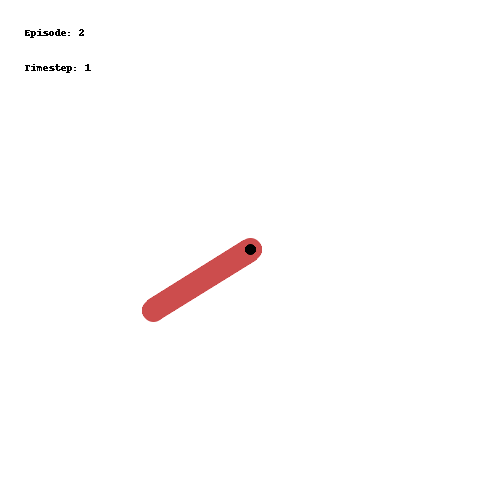

In [15]:
from IPython import display
display.Image(open('/content/drive/MyDrive/Gif/DDPG_agent.gif','rb').read())